In [1]:
!pip install --quiet matplotlib

In [2]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data_path = 'data'

data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder(root=data_path, transform=data_transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if i % 10 == 9:
                print(f"[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 10:.3f}")
                running_loss = 0.0

In [7]:
best_lr = 0
best_batch_size = 0
best_epochs = 0
best_accuracy = 0.0
best_model = None

for lr in [0.001, 0.005]:
    for bs in [16, 32]:
        for epochs in [5, 10]:
            train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

            model = CNN().to(device)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)

            print(f"\nHyperparameters: lr={lr}, batch_size={bs}, epochs={epochs}")
            for epoch in range(epochs):
                # Training loop
                model.train()
                running_loss = 0.0
                for i, data in enumerate(train_loader, 0):
                    inputs, labels = data
                    inputs, labels = inputs.to(device), labels.to(device) 
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    running_loss += loss.item()

            # Testing loop
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device) 
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            accuracy = correct / total
            print(f"Test Accuracy: {accuracy * 100:.2f}%")

            # Check if the current combination is the best
            if accuracy > best_accuracy:
                best_lr = lr
                best_batch_size = bs
                best_epochs = epochs
                best_accuracy = accuracy
                best_model = model.state_dict()

print("\nBest Hyperparameters:")
print(f"Learning Rate: {best_lr}")
print(f"Batch Size: {best_batch_size}")
print(f"Epochs: {best_epochs}")
print(f"Best Test Accuracy: {best_accuracy * 100:.2f}%")

torch.save(best_model, 'best_CNN_model.pth')


Hyperparameters: lr=0.001, batch_size=16, epochs=5
Test Accuracy: 94.75%

Hyperparameters: lr=0.001, batch_size=16, epochs=10
Test Accuracy: 96.88%

Hyperparameters: lr=0.001, batch_size=32, epochs=5
Test Accuracy: 97.12%

Hyperparameters: lr=0.001, batch_size=32, epochs=10
Test Accuracy: 96.62%

Hyperparameters: lr=0.005, batch_size=16, epochs=5
Test Accuracy: 51.12%

Hyperparameters: lr=0.005, batch_size=16, epochs=10
Test Accuracy: 94.25%

Hyperparameters: lr=0.005, batch_size=32, epochs=5
Test Accuracy: 92.75%

Hyperparameters: lr=0.005, batch_size=32, epochs=10
Test Accuracy: 51.12%

Best Hyperparameters:
Learning Rate: 0.001
Batch Size: 32
Epochs: 5
Best Test Accuracy: 97.12%
Training time: 316.1259255409241


[Epoch 1, Batch 10] Loss: 0.941
[Epoch 1, Batch 20] Loss: 0.693
[Epoch 1, Batch 30] Loss: 0.679
[Epoch 1, Batch 40] Loss: 0.654
[Epoch 1, Batch 50] Loss: 0.658
[Epoch 1, Batch 60] Loss: 0.622
[Epoch 1, Batch 70] Loss: 0.561
[Epoch 1, Batch 80] Loss: 0.549
[Epoch 1, Batch 90] Loss: 0.550
[Epoch 1, Batch 100] Loss: 0.553
[Epoch 2, Batch 10] Loss: 0.440
[Epoch 2, Batch 20] Loss: 0.451
[Epoch 2, Batch 30] Loss: 0.414
[Epoch 2, Batch 40] Loss: 0.459
[Epoch 2, Batch 50] Loss: 0.432
[Epoch 2, Batch 60] Loss: 0.296
[Epoch 2, Batch 70] Loss: 0.329
[Epoch 2, Batch 80] Loss: 0.256
[Epoch 2, Batch 90] Loss: 0.251
[Epoch 2, Batch 100] Loss: 0.189
[Epoch 3, Batch 10] Loss: 0.145
[Epoch 3, Batch 20] Loss: 0.118
[Epoch 3, Batch 30] Loss: 0.086
[Epoch 3, Batch 40] Loss: 0.125
[Epoch 3, Batch 50] Loss: 0.116
[Epoch 3, Batch 60] Loss: 0.081
[Epoch 3, Batch 70] Loss: 0.106
[Epoch 3, Batch 80] Loss: 0.060
[Epoch 3, Batch 90] Loss: 0.062
[Epoch 3, Batch 100] Loss: 0.090
[Epoch 4, Batch 10] Loss: 0.034
[Epoc

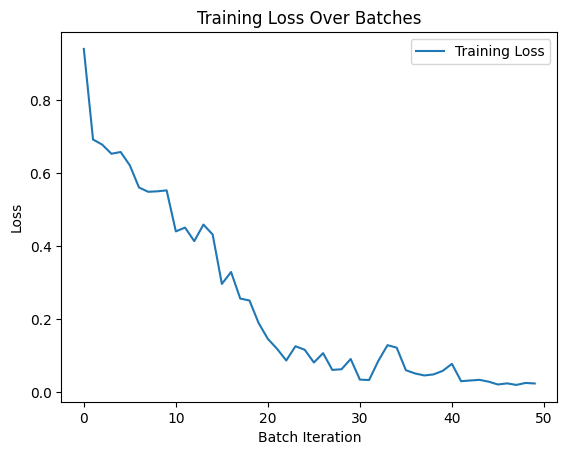

In [8]:
import matplotlib.pyplot as plt

loss_values = []

train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_lr)

model.train()

for epoch in range(best_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device) 
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 10 == 9:
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 10:.3f}")
            loss_values.append(running_loss / 10)  # Record the loss value for plotting
            running_loss = 0.0

plt.plot(loss_values, label='Training Loss')
plt.title('Training Loss Over Batches')
plt.xlabel('Batch Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()